# Word Embedding

**How do we represent the meaning of a word?**

Definition:meaning(Webster dictionary)
- the idea that is represented by a word, phrase, etc.
- the idea that a person wants to express by using words, signs, etc.
- the idea that is expressed in a work of writing, art, etc. Commonest linguistic way of thinking of meaning: 
- signifier $\Leftrightarrow$ signified(idea or thing)=denotation

**How do we have usable meaning in a computer?**

Common answer: Use a taxonomy like WordNet that has hypernyms(is-a) relationships
```python
from nlyk.corpus import wordnet as wn
panda = wn.synset('panda.n.01')
hyper = lambda s: s.hypernyms()
list(panda.closure(hyper))
```

**Problems with this discrete representatiom**
- Great as a resource but missing nuances, e.g., **synonyms**:
   - adept, expert, good, practiced, proficient, skillful?
- Missing new words(impossible to keep up date): wicked, badass, nifty, crack, ace, wizard, genius, ninja
- Subjective
- Requires human labor to create and adapt
- Hard to compute accurate word similarity

The vast majority of rule-based and statistical NLP work regards words as atomic symbols.

In vector space terms, this is a vector with one 1 and a lot of zeros:$$[0\quad 0\quad 0...0\quad 1\quad 0...0]$$
Dimensionality:20K(speech)-50K(PTB)-500K(big vocab)-13M(Google 1T)

We call this a one-hot representation

It is a localist representation.

Its problem, e.g., for web search
- If user searches for [<span style="color:pink">Dell notebook battery size</span>], we would like to match documents with "<span style="color:pink">Dell laptop battery capacity</span>"
- If user searches for [<span style="color:pink">Seattle motel</span>], we would like to match documents containing "<span style="color:pink">Seattle hotel</span>"

But

motel $[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]^T$

hotel $[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] = 0$

Our query and document vectors are <span style="color:purple">orthogonal</span>

There is no natural notion of similarity in a set of one-hot vectors

Could deal with similarity separately;instead we explore a direct approach where vectors encode it

**Distributional similarity based representations**

You can get a lot of value by representing a word by means of its neighbors

<span style="color:blue">"You shall know a word by the company it keeps"</span>

One of the most successful ideas of modern statistical NLP

**Word meaning is defined in terms of vectors**

We will build a dense vector for each word type, chosen so that it is good at predicting other words appearing in its context...those other words also being represented by vectors...it all gets a bit recursive.

**Directly learning low-dimensional word vectors**

Old idea. Relevant for this lecture \& deep learning:
- Learning representations by back-propagating errors
- A neural probabilistic language model
- NLP(almost) from Scratch
- A recent, even simpler and faster model: word2vec.

**How do we select input and output words?**
- Method 1: continuous bag-of-word(CBOW)
- Method 2: skip-gram(SG)

![CBOW and Skip-Gram](images/image1-3.png)

$$E=-\log p(w_{O,1},w_{O,2},...,w_{O,C}|w_I)$$
- Loss function is negative probability of predictions of context words
- The hidden layer simply selects a row of $W$ based on the input word
   $$h=x^TW=W_{(k,\cdot)}$$
- This is then mapped by another matrix to an output probability

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy
from collections import defaultdict

In [12]:
# 1. 准备一个简单的语料库
# 这个语料库特意设计得让 'king' 和 'queen' 以及 'man' 和 'woman' 出现在相似的上下文中
corpus = [
    "The king is a strong man",
    "The queen is a wise woman",
    "A man can be a king",
    "A woman can be a queen",
    "The king rules the country",
    "The queen leads the people"
]

# 2. 数据预处理
# 将所有句子合并成一个单词列表
words = []
for sentence in corpus:
    words.extend(sentence.lower().split())

# 创建词汇表
# 使用 defaultdict 方便处理未见过的词
vocab = defaultdict(lambda: len(vocab))
# 使用 set 去重，然后构建词汇表
unique_words = set(words)
for word in unique_words:
    vocab[word] # 这行代码会触发 defaultdict 的 lambda 函数，为每个词分配一个唯一索引

# 创建反向映射，方便从索引找回单词
ix_to_word = {i: word for word, i in vocab.items()}
vocab_size = len(vocab)

print(f"词汇表大小 (Vocab size): {vocab_size}")
print(f"词汇表示例 (Vocab example): {list(vocab.items())[:5]}")
print("-" * 30)

# 3. 生成 Skip-gram 训练数据
# Skip-gram 的任务是：给定一个中心词，预测它周围的上下文词
# 我们定义一个 "窗口大小" (window_size)，表示中心词左右各看几个词
window_size = 2
training_data = []

for i, word in enumerate(words):
    center_word_idx = vocab[word]
    # 遍历窗口内的上下文词
    for j in range(i - window_size, i + window_size + 1):
        # 确保索引在合法范围内，并且不是中心词本身
        if j >= 0 and j < len(words) and i != j:
            context_word_idx = vocab[words[j]]
            training_data.append((center_word_idx, context_word_idx))

print(f"生成训练数据对 {len(training_data)} 个")
print(f"训练数据示例 (center_word_idx, context_word_idx):")
# 打印前5个训练样本，并显示其对应的单词
for center_idx, context_idx in training_data[:5]:
    print(f"  ({ix_to_word[center_idx]}, {ix_to_word[context_idx]})")

词汇表大小 (Vocab size): 15
词汇表示例 (Vocab example): [('wise', 0), ('leads', 1), ('is', 2), ('rules', 3), ('the', 4)]
------------------------------
生成训练数据对 130 个
训练数据示例 (center_word_idx, context_word_idx):
  (the, king)
  (the, is)
  (king, the)
  (king, is)
  (king, a)


In [13]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        # 定义中心词的嵌入层 (W)
        # 这是一个大小为 (vocab_size, embedding_dim) 的矩阵
        # 当输入一个词的索引时，它会返回该词的嵌入向量
        self.center_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # 定义上下文词的嵌入层 (W')
        # 这也是一个大小为 (vocab_size, embedding_dim) 的矩阵
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, center_word_idx):
        # 1. 获取中心词的嵌入向量
        # center_word_idx 的 shape: (batch_size)
        # center_embedding 的 shape: (batch_size, embedding_dim)
        center_embedding = self.center_embeddings(center_word_idx)
        
        # 2. 计算中心词向量与所有上下文词向量的点积
        # self.context_embeddings.weight 的 shape: (vocab_size, embedding_dim)
        # 我们希望得到每个词作为上下文的得分，所以进行矩阵乘法
        # (batch_size, embedding_dim) @ (embedding_dim, vocab_size) -> (batch_size, vocab_size)
        scores = torch.matmul(center_embedding, self.context_embeddings.weight.t())
        
        # 返回的是 logits（原始得分），后续会传入 CrossEntropyLoss
        # CrossEntropyLoss 会在内部自动计算 log_softmax
        return scores

In [14]:
# 超参数
EMBEDDING_DIM = 10  # 词向量维度，实际应用中通常是 50, 100, 300
LEARNING_RATE = 0.01 # 学习率
EPOCHS = 50          # 训练轮数

# 初始化模型、损失函数和优化器
model = SkipGramModel(vocab_size, EMBEDDING_DIM)
# 损失函数：交叉熵损失。它适用于多分类问题，并且会自动处理 LogSoftmax
loss_function = nn.CrossEntropyLoss()
# 优化器：Adam 是一个常用的、效果很好的优化器
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [15]:
# 开始训练
for epoch in range(EPOCHS):
    total_loss = 0
    for center_word_idx, context_word_idx in training_data:
        # 将输入数据转换为 PyTorch Tensor
        # PyTorch 的 Embedding 层和 CrossEntropyLoss 都需要 LongTensor 类型的索引
        center_tensor = torch.LongTensor([center_word_idx])
        context_tensor = torch.LongTensor([context_word_idx])
        
        # 1. 梯度清零
        optimizer.zero_grad()
        
        # 2. 前向传播，得到预测得分
        scores = model(center_tensor)
        
        # 3. 计算损失
        # scores 的 shape 是 (1, vocab_size)，context_tensor 的 shape 是 (1)
        # CrossEntropyLoss 正好需要这种格式的输入
        loss = loss_function(scores, context_tensor)
        
        # 4. 反向传播
        loss.backward()
        
        # 5. 更新参数
        optimizer.step()
        
        total_loss += loss.item()
        
    # 每 10 轮打印一次损失
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(training_data):.4f}")

print("\n训练完成!")

Epoch 10/50, Loss: 2.1061
Epoch 20/50, Loss: 2.0184
Epoch 30/50, Loss: 1.9961
Epoch 40/50, Loss: 1.9838
Epoch 50/50, Loss: 1.9753

训练完成!


In [16]:
# 提取学习到的词向量 (我们通常使用中心词的嵌入作为最终的词向量)
word_vectors = model.center_embeddings.weight.data

def find_most_similar(word, top_n=5):
    """
    寻找与给定单词最相似的单词
    """
    if word not in vocab:
        print(f"'{word}' 不在词汇表中。")
        return

    # 获取输入单词的向量
    input_vec = word_vectors[vocab[word]].unsqueeze(0) # 增加一个维度以进行广播
    
    # 计算余弦相似度
    # (1, dim) @ (dim, vocab_size) -> (1, vocab_size)
    similarities = torch.matmul(input_vec, word_vectors.t()) / (torch.norm(input_vec) * torch.norm(word_vectors, dim=1))
    similarities = similarities.squeeze(0) # 降维
    
    # 排序并获取 top_n 结果
    # argsort 默认是升序，所以我们取最后的 n+1 个（因为最相似的是它自己）
    top_indices = torch.argsort(similarities, descending=True)[1:top_n+1]
    
    print(f"与 '{word}' 最相似的词:")
    for idx in top_indices:
        sim_score = similarities[idx].item()
        print(f"  - {ix_to_word[idx.item()]} (相似度: {sim_score:.3f})")

# --- 验证结果 ---
# 注意：由于我们的语料库非常小，结果可能不完美，但应该能展示出一些有趣的模式。
# 例如，'king' 应该与 'queen', 'man' 比较相似。
print("\n--- 词向量相似度测试 ---")
find_most_similar('king')
print("-" * 20)
find_most_similar('queen')
print("-" * 20)
find_most_similar('man')


--- 词向量相似度测试 ---
与 'king' 最相似的词:
  - leads (相似度: 0.593)
  - strong (相似度: 0.448)
  - be (相似度: 0.426)
  - can (相似度: 0.367)
  - wise (相似度: 0.323)
--------------------
与 'queen' 最相似的词:
  - rules (相似度: 0.736)
  - the (相似度: 0.346)
  - king (相似度: 0.303)
  - is (相似度: 0.291)
  - people (相似度: 0.265)
--------------------
与 'man' 最相似的词:
  - is (相似度: 0.456)
  - wise (相似度: 0.422)
  - leads (相似度: 0.361)
  - can (相似度: 0.316)
  - be (相似度: 0.288)


## Applications of Word Vectors

### 1. Word Similarity

Classic Methods: Edit Distance, WordNet, Porter's Stemmer, Lemmatization using dictionaries.
- Easily identifies similar words and synonyms since they occur in similar contexts
- Stemming(thought->think)
- Inflections, Tense forms
- e.g. Think, thought, ponder, pondering
- e.g. Plane, Aircraft, Flight

In [17]:
# 我们需要用到以下变量: model, vocab, ix_to_word, word_vectors

# 为了演示情感分析，我们手动为词汇表添加一些带有感情色彩的词
# 并为它们分配随机的词向量（因为它们未在原始语料中训练）
# 在真实场景中，这些词应该在包含情感内容的语料中进行训练
additional_words = ['good', 'happy', 'bad', 'sad', 'hate']
for word in additional_words:
    if word not in vocab:
        # 添加到词汇表
        new_idx = len(vocab)
        vocab[word] = new_idx
        ix_to_word[new_idx] = word
        # 扩展词向量矩阵，并添加一个随机初始化的向量
        random_vec = torch.randn(1, EMBEDDING_DIM)
        word_vectors = torch.cat([word_vectors, random_vec], 0)

# 更新词汇表大小
vocab_size = len(vocab)

print("词汇表和词向量已更新，准备演示应用。")
print(f"新的词汇表大小: {vocab_size}")

# 重新定义一个更通用的相似度函数，方便后面使用
def get_cosine_similarity(vec1, vec2):
    """计算两个向量的余弦相似度"""
    return torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))

词汇表和词向量已更新，准备演示应用。
新的词汇表大小: 20


In [18]:
# ### 1. 词语相似度 (Word Similarity) ###

def find_most_similar(word, top_n=5):
    """
    寻找与给定单词最相似的单词 (复用之前的函数)
    """
    if word not in vocab:
        print(f"'{word}' 不在词汇表中。")
        return

    input_vec = word_vectors[vocab[word]]
    similarities = []
    for i in range(vocab_size):
        sim = get_cosine_similarity(input_vec, word_vectors[i]).item()
        similarities.append((ix_to_word[i], sim))
    
    # 按相似度降序排序，忽略第一个（即单词本身）
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    print(f"--- 与 '{word}' 最相似的词 ---")
    for sim_word, sim_score in similarities[1:top_n+1]:
        print(f"  - {sim_word} (相似度: {sim_score:.3f})")

def word_analogy(w1, w2, w3, top_n=5):
    """
    执行词语类比任务，例如: w1 - w2 + w3 = ? (king - man + woman = queen)
    """
    if not all(w in vocab for w in [w1, w2, w3]):
        print("一个或多个单词不在词汇表中。")
        return

    # 获取向量
    v1 = word_vectors[vocab[w1]]
    v2 = word_vectors[vocab[w2]]
    v3 = word_vectors[vocab[w3]]
    
    # 计算目标向量
    target_vec = v1 - v2 + v3
    
    # 计算与所有词的相似度
    similarities = []
    for i in range(vocab_size):
        # 忽略输入词
        if ix_to_word[i] in [w1, w2, w3]:
            continue
        sim = get_cosine_similarity(target_vec, word_vectors[i]).item()
        similarities.append((ix_to_word[i], sim))

    similarities.sort(key=lambda x: x[1], reverse=True)

    print(f"--- 词语类比: {w1} - {w2} + {w3} ≈ ? ---")
    for word, score in similarities[:top_n]:
        print(f"  - {word} (相似度: {score:.3f})")


# --- 运行演示 ---
print("--- (1) 词语相似度演示 ---")
find_most_similar('king')

print("\n--- (2) 词语类比演示 ---")
word_analogy('king', 'man', 'woman')

--- (1) 词语相似度演示 ---
--- 与 'king' 最相似的词 ---
  - good (相似度: 0.602)
  - leads (相似度: 0.593)
  - strong (相似度: 0.448)
  - be (相似度: 0.426)
  - can (相似度: 0.367)

--- (2) 词语类比演示 ---
--- 词语类比: king - man + woman ≈ ? ---
  - good (相似度: 0.645)
  - queen (相似度: 0.560)
  - be (相似度: 0.392)
  - can (相似度: 0.382)
  - strong (相似度: 0.381)


### 2.Machine Translation
Classic Methods: Rule-bases machine translation, morphological transformation.

In [19]:
# ### 2. 机器翻译 (Machine Translation) ###

# 这是一个概念演示，说明词向量如何作为更复杂模型的输入
# 假设我们有一个简单的日英词典
eng_to_jp = {
    'king': '王 (Ō)',
    'queen': '女王 (Joō)',
    'man': '男 (Otoko)',
    'woman': '女 (Onna)'
}

def pseudo_translate(sentence):
    """
    一个伪翻译函数，演示如何使用词向量查找和替换。
    """
    words = sentence.lower().split()
    translated_sentence = []
    
    for word in words:
        if word in eng_to_jp:
            # 找到最直接的翻译
            translated_word = eng_to_jp[word]
        elif word in vocab:
            # 如果没有直接翻译，尝试找一个最相似的词进行翻译
            # 这模拟了处理未知词的一种策略
            input_vec = word_vectors[vocab[word]]
            
            # 在我们已知的翻译词典中找最相似的词
            best_sim = -1
            best_match = None
            for eng_word in eng_to_jp.keys():
                sim = get_cosine_similarity(input_vec, word_vectors[vocab[eng_word]])
                if sim > best_sim:
                    best_sim = sim
                    best_match = eng_word
            
            translated_word = f"({eng_to_jp[best_match]}?)" # 标记为不确定翻译
        else:
            translated_word = word # 无法处理的词
        
        translated_sentence.append(translated_word)
        
    return " ".join(translated_sentence)

# --- 运行演示 ---
# 假设我们要翻译一个包含我们训练过的词的句子
test_sentence = "the strong man is a king"
translation = pseudo_translate(test_sentence)

print(f"--- 机器翻译概念演示 ---")
print(f"原始句子: '{test_sentence}'")
print(f"伪翻译结果: '{translation}'")

--- 机器翻译概念演示 ---
原始句子: 'the strong man is a king'
伪翻译结果: '(女王 (Joō)?) (王 (Ō)?) 男 (Otoko) (男 (Otoko)?) (男 (Otoko)?) 王 (Ō)'


### 3. Part-of-Speech and Named Entity Recognition
Classic Methods: Sequential Models(MEMM, Conditional Random Fields), Logistic Regression

In [20]:
# ### 3. POS 和 NER 的输入准备演示 ###

def get_sentence_vector_sequence(sentence):
    """
    将一个句子转换成一个词向量序列。
    这是序列标注模型的标准输入格式。
    """
    words = sentence.lower().split()
    # 使用 0 向量代表未在词汇表中的词 (OOV - Out Of Vocabulary)
    vectors = [word_vectors[vocab[w]] if w in vocab else torch.zeros(EMBEDDING_DIM) for w in words]
    # 将向量列表堆叠成一个 tensor
    return torch.stack(vectors)

# 假设我们有一个简单的序列标注模型（仅为演示结构）
class SimpleSequenceTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_tags):
        super().__init__()
        # 假设模型有一个线性层处理输入的词向量
        self.linear = nn.Linear(embedding_dim, hidden_dim)
        # ... 后续会有 LSTM, CRF 等复杂结构
        self.output_layer = nn.Linear(hidden_dim, num_tags)
    
    def forward(self, sentence_vectors):
        # 接收词向量序列作为输入
        hidden = torch.relu(self.linear(sentence_vectors))
        tag_scores = self.output_layer(hidden)
        return tag_scores

# --- 运行演示 ---
test_sentence = "the king rules"
sentence_tensor = get_sentence_vector_sequence(test_sentence)

# 假设我们要进行 POS 标注，标签为 {Determiner, Noun, Verb} -> {0, 1, 2}
tagger_model = SimpleSequenceTagger(embedding_dim=EMBEDDING_DIM, hidden_dim=16, num_tags=3)
output_scores = tagger_model(sentence_tensor)

print(f"--- POS/NER 输入准备演示 ---")
print(f"原始句子: '{test_sentence}'")
print(f"转换后的词向量序列 shape: {sentence_tensor.shape}")
print(f"（这表示句子有 {sentence_tensor.shape[0]} 个词，每个词用 {sentence_tensor.shape[1]} 维向量表示）")
print(f"\n模拟模型输出的各词标签得分 shape: {output_scores.shape}")
print(f"（这表示对每个词，都预测了 {output_scores.shape[1]} 种标签的可能性）")

--- POS/NER 输入准备演示 ---
原始句子: 'the king rules'
转换后的词向量序列 shape: torch.Size([3, 10])
（这表示句子有 3 个词，每个词用 10 维向量表示）

模拟模型输出的各词标签得分 shape: torch.Size([3, 3])
（这表示对每个词，都预测了 3 种标签的可能性）


### 4. Relation Extraction
Classic Methods: OpenIE, Linear programing models, Bootstrapping

In [21]:
# ### 4. 关系抽取 (Relation Extraction) ###

def get_relation_feature_vector(sentence, entity1, entity2):
    """
    为关系抽取任务创建一个简单的特征向量。
    一个常见的策略是拼接两个实体的词向量。
    """
    if entity1 not in vocab or entity2 not in vocab:
        return None
        
    vec1 = word_vectors[vocab[entity1]]
    vec2 = word_vectors[vocab[entity2]]
    
    # 拼接两个实体的向量，形成一个特征向量
    return torch.cat([vec1, vec2])

# 假设有一个分类器，用来判断两个实体间是否存在 "rules" 关系
relation_classifier = nn.Linear(EMBEDDING_DIM * 2, 2) # 输入是拼接后的向量，输出是 "有关系/无关系"

# --- 运行演示 ---
sentence = "the king rules the country"
entity1 = "king"
entity2 = "country"

# 创建特征向量
feature_vector = get_relation_feature_vector(sentence, entity1, entity2)

if feature_vector is not None:
    # 模型的输入 shape 需要是 (batch_size, feature_dim)
    output = relation_classifier(feature_vector.unsqueeze(0))
    
    print(f"--- 关系抽取概念演示 ---")
    print(f"句子: '{sentence}'")
    print(f"实体1: '{entity1}', 实体2: '{entity2}'")
    print(f"拼接后的特征向量维度: {feature_vector.shape[0]}")
    print(f"模拟分类器输出 (logits): {output.data}")
    print(f"（分类器将基于这个特征向量来判断 '{entity1}' 和 '{entity2}' 是否存在'rules'关系）")

--- 关系抽取概念演示 ---
句子: 'the king rules the country'
实体1: 'king', 实体2: 'country'
拼接后的特征向量维度: 20
模拟分类器输出 (logits): tensor([[-0.5599, -0.0928]])
（分类器将基于这个特征向量来判断 'king' 和 'country' 是否存在'rules'关系）


### 5. Sentiment Analysis
Classic Methods: Naive Bayes, Random Forests/SVM
- Classifying sentences as positives and negative
- Building sentiment lexicons using seed sentiment
- No need for classifiers, we can just use cosine distances to compare unseen reviews to known reviews.

In [22]:
# ### 5. 情感分析 (Sentiment Analysis) ###

def get_sentence_vector_avg(sentence):
    """
    通过平均句子中所有词的向量来得到句子向量。
    """
    words = sentence.lower().split()
    vectors = [word_vectors[vocab[w]] for w in words if w in vocab]
    
    if not vectors:
        return torch.zeros(EMBEDDING_DIM)
    
    # 将向量列表堆叠并沿第0维求平均
    return torch.stack(vectors).mean(dim=0)

# --- 运行演示 ---
# 定义几个原型情感向量
# 在真实应用中，这些原型可以从大量标注数据中学习得到
positive_prototype = get_sentence_vector_avg("happy good king")
negative_prototype = get_sentence_vector_avg("sad bad hate")

# 测试新句子
test_sentence_1 = "the queen is a wise woman"
test_sentence_2 = "a bad man"

# 获取测试句子的向量
vec1 = get_sentence_vector_avg(test_sentence_1)
vec2 = get_sentence_vector_avg(test_sentence_2)

# 计算与原型向量的相似度
sim_to_pos_1 = get_cosine_similarity(vec1, positive_prototype)
sim_to_neg_1 = get_cosine_similarity(vec1, negative_prototype)

sim_to_pos_2 = get_cosine_similarity(vec2, positive_prototype)
sim_to_neg_2 = get_cosine_similarity(vec2, negative_prototype)


print(f"--- 情感分析演示 ---")
print(f"句子1: '{test_sentence_1}'")
print(f"  与正面原型的相似度: {sim_to_pos_1:.3f}")
print(f"  与负面原型的相似度: {sim_to_neg_1:.3f}")
print(f"  => 情感倾向: {'正面' if sim_to_pos_1 > sim_to_neg_1 else '负面'}")

print(f"\n句子2: '{test_sentence_2}'")
print(f"  与正面原型的相似度: {sim_to_pos_2:.3f}")
print(f"  与负面原型的相似度: {sim_to_neg_2:.3f}")
print(f"  => 情感倾向: {'正面' if sim_to_pos_2 > sim_to_neg_2 else '负面'}")

--- 情感分析演示 ---
句子1: 'the queen is a wise woman'
  与正面原型的相似度: 0.184
  与负面原型的相似度: 0.214
  => 情感倾向: 负面

句子2: 'a bad man'
  与正面原型的相似度: -0.378
  与负面原型的相似度: 0.548
  => 情感倾向: 负面


### 6. Co-reference Resolution
Chaining entity mentions across multiple documents - can we find and unify the multiple contexts in which mentions occurs?

In [23]:
# ### 6. 共指消解 (Co-reference Resolution) ###

def get_context_vector(sentence, mention_index, window_size=2):
    """
    获取一个指代词 (mention) 的上下文向量。
    这是通过平均其周围词的向量得到的。
    """
    words = sentence.lower().split()
    
    start = max(0, mention_index - window_size)
    end = min(len(words), mention_index + window_size + 1)
    
    context_words = [w for i, w in enumerate(words[start:end]) if w in vocab and i != mention_index-start]

    if not context_words:
        return torch.zeros(EMBEDDING_DIM)
        
    vectors = [word_vectors[vocab[w]] for w in context_words]
    return torch.stack(vectors).mean(dim=0)

# --- 运行演示 ---
# 假设我们有两句话，包含两个实体 "king" 和 "man"
# 在这个语料中，它们可能指代同一个人
sentence1 = "the king is strong" # "king" 在索引 1
sentence2 = "a man rules the country" # "man" 在索引 1

# 获取两个指代词的上下文向量
context_vec1 = get_context_vector(sentence1, mention_index=1)
context_vec2 = get_context_vector(sentence2, mention_index=1)
# 获取一个无关词的上下文向量作为对比
context_vec3 = get_context_vector(sentence2, mention_index=3) # "country"

# 比较上下文向量的相似度
sim_between_mentions = get_cosine_similarity(context_vec1, context_vec2)
sim_to_unrelated = get_cosine_similarity(context_vec1, context_vec3)

print(f"--- 共指消解概念演示 ---")
print(f"指代1 ('king') 的上下文向量与指代2 ('man') 的上下文向量的相似度: {sim_between_mentions:.3f}")
print(f"指代1 ('king') 的上下文向量与无关词 ('country') 的上下文向量的相似度: {sim_to_unrelated:.3f}")
print("\n如果两个指代的上下文相似度高，则它们更可能指向同一实体。")

--- 共指消解概念演示 ---
指代1 ('king') 的上下文向量与指代2 ('man') 的上下文向量的相似度: 0.422
指代1 ('king') 的上下文向量与无关词 ('country') 的上下文向量的相似度: 0.360

如果两个指代的上下文相似度高，则它们更可能指向同一实体。


### 7. Clustering
Words in the same class naturally occur in similar contexts, and this feature vector can directly be used with any conventional clustering algorithms (K-means, agglomerative, etc.) Human doesn't have to waste time hand-picking useful word features to cluster on.

--- 词向量聚类演示 ---
Cluster 0: leads, is, can, man, woman, a, be, happy, sad, hate
Cluster 1: rules, the, people, queen, king, good
Cluster 2: wise, strong
Cluster 3: country, bad


e:\Download\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Windows\Temp\ipykernel_39452\821182533.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(X_pca[i, 0], X_pca[i, 1], c=plt.cm.get_cmap("viridis")(labels[i] / n_clusters))
C:\Windows\Temp\ipykernel_39452\821182533.py:44: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or

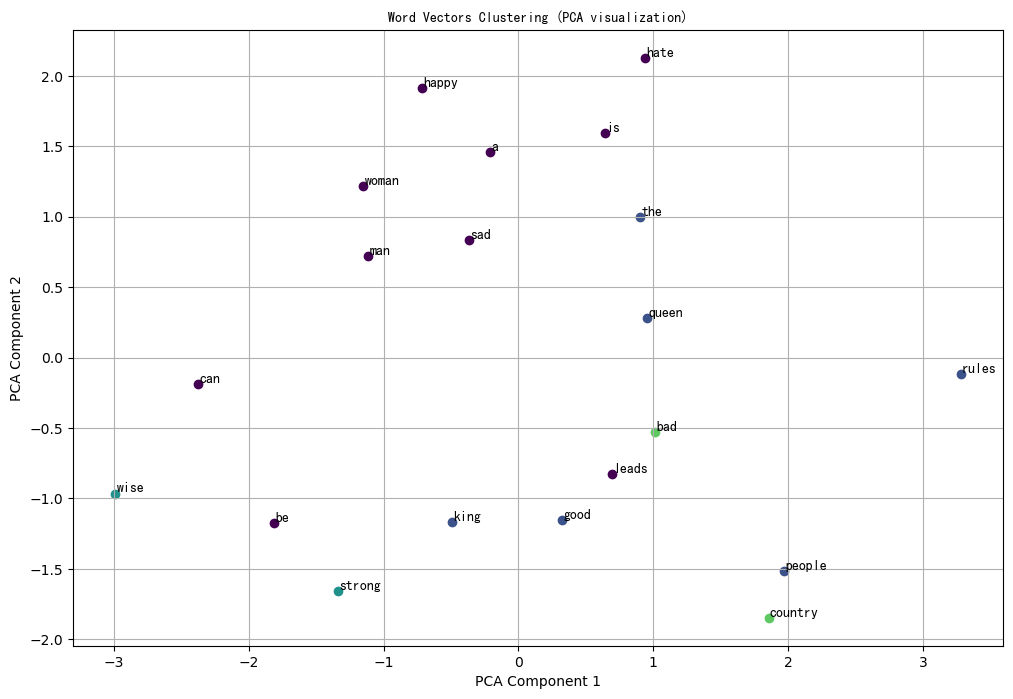

In [25]:
# ### 7. 聚类 (Clustering) ###
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 为了在 matplotlib 中显示中文
# 请确保你的环境中有一个支持中文的字体文件（例如 simhei.ttf）
# 如果没有，可以从网上下载一个放到当前目录
# 如果字体加载失败，中文标签将显示为方框
try:
    # 尝试加载一个常见的中文字体
    # my_font = fm.FontProperties(fname='/usr/share/fonts/wenquanyi/wqy-microhei/wqy-microhei.ttc') # for linux
    my_font = fm.FontProperties(fname='C:/Windows/Fonts/simhei.ttf') # for windows
except:
    print("警告：未找到中文字体，标签可能无法正常显示。")
    my_font = fm.FontProperties()


# 将 torch tensor 转换为 numpy array 供 scikit-learn 使用
X = word_vectors.numpy()

# 设置聚类数量
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(X)
labels = kmeans.labels_

# 为了可视化，使用 PCA 将高维词向量降到2维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# --- 运行演示 ---
print(f"--- 词向量聚类演示 ---")
clusters = [[] for _ in range(n_clusters)]
for i, label in enumerate(labels):
    clusters[label].append(ix_to_word[i])

for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {', '.join(cluster)}")

# 可视化
plt.figure(figsize=(12, 8))
for i in range(len(X_pca)):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], c=plt.cm.get_cmap("viridis")(labels[i] / n_clusters))
    plt.text(X_pca[i, 0] + 0.01, X_pca[i, 1] + 0.01, ix_to_word[i], fontproperties=my_font)

plt.title("Word Vectors Clustering (PCA visualization)", fontproperties=my_font)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

### 8. Semantic Analysis of Documents
Build word distributions for various topics, etc.

In [26]:
# ### 8. 文档语义分析 (Semantic Analysis of Documents) ###

# 我们复用之前定义的 get_sentence_vector_avg 函数，这里把它看作 get_document_vector
get_document_vector = get_sentence_vector_avg

# --- 运行演示 ---
# 从我们的原始语料中选择两个文档（句子）
doc1 = "The king is a strong man"
doc2 = "A woman can be a queen"
doc3 = "The queen leads the people"

# 计算它们的文档向量
doc1_vec = get_document_vector(doc1)
doc2_vec = get_document_vector(doc2)
doc3_vec = get_document_vector(doc3)

# 计算文档之间的语义相似度
sim_1_2 = get_cosine_similarity(doc1_vec, doc2_vec)
sim_1_3 = get_cosine_similarity(doc1_vec, doc3_vec)
sim_2_3 = get_cosine_similarity(doc2_vec, doc3_vec)

print(f"--- 文档语义分析演示 ---")
print(f"文档1: '{doc1}'")
print(f"文档2: '{doc2}'")
print(f"文档3: '{doc3}'")
print("-" * 20)
print(f"文档1和文档2的相似度: {sim_1_2:.3f}")
print(f"文档1和文档3的相似度: {sim_1_3:.3f}")
print(f"文档2和文档3的相似度: {sim_2_3:.3f}")

# 期望 doc2 和 doc3 更相似，因为它们都和 'queen' 相关
print(f"\n分析：文档2和文档3更相似，因为它们都围绕 'queen' 展开。")

--- 文档语义分析演示 ---
文档1: 'The king is a strong man'
文档2: 'A woman can be a queen'
文档3: 'The queen leads the people'
--------------------
文档1和文档2的相似度: 0.404
文档1和文档3的相似度: 0.329
文档2和文档3的相似度: -0.298

分析：文档2和文档3更相似，因为它们都围绕 'queen' 展开。
